# Importing all the important Libraries

In [37]:
#Importing Important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.fft import fft, ifft,fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Data Collection from Yahoo finance(Free open source)

In [38]:
# Defining the ticker symbol for Apple 
#ticker_symbol = 'AAPL'
ticker_symbol = 'AMZN'

# Get data for the ticker symbol
#df = yf.download(ticker_symbol,start = '2022-01-01').iloc[::-1]
df = yf.download(ticker_symbol,start = '2020-01-01').iloc[::-1]
#Change date index to datetime type
df.index = pd.to_datetime(df.index)
#delete this
df = df.iloc[::-1]

[*********************100%%**********************]  1 of 1 completed


# Plotting the data

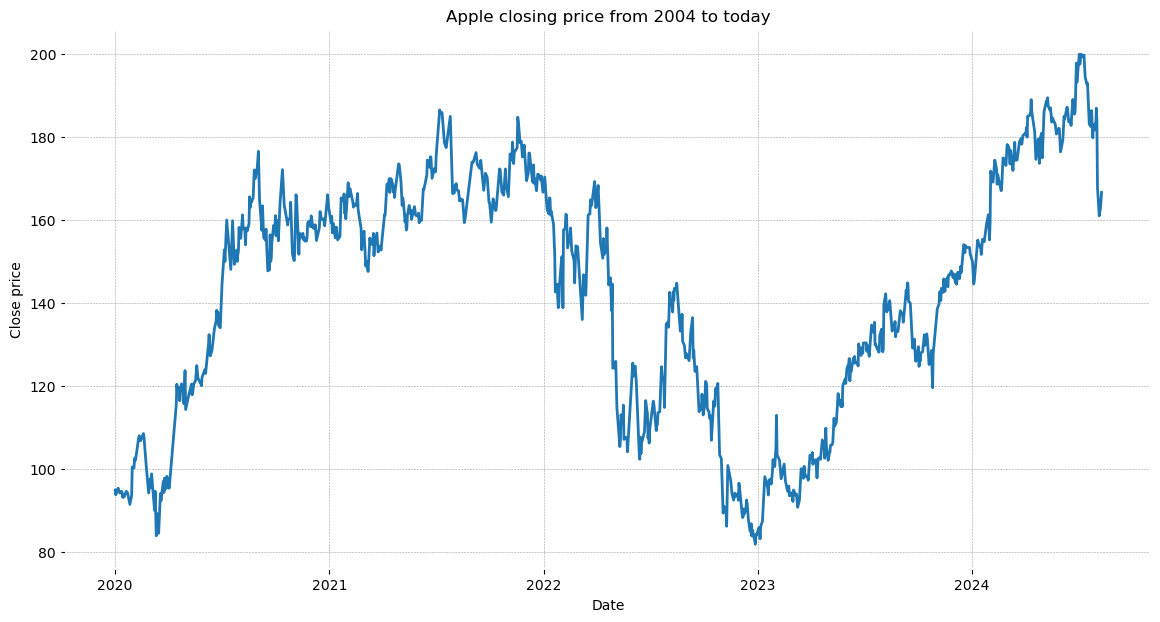

In [39]:
#Plotting lineplot from 2004 to todays date
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label = "APPL closing price")
plt.title('Apple closing price from 2004 to today')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.show()

In [40]:
#Visualisation of volume plot

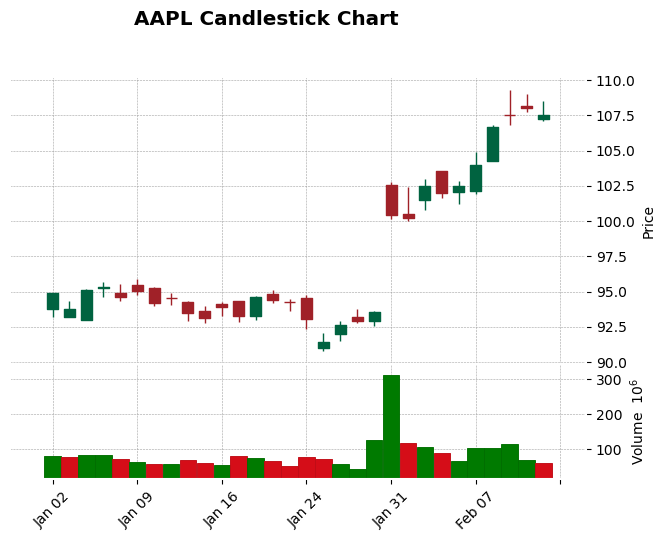

In [41]:
#candlestick chart for last 30 days to find out any recurring pattern 
import mplfinance as mpf
mpf.plot(df.iloc[0:30], type='candle', style='charles', title='AAPL Candlestick Chart', volume=True)


[]

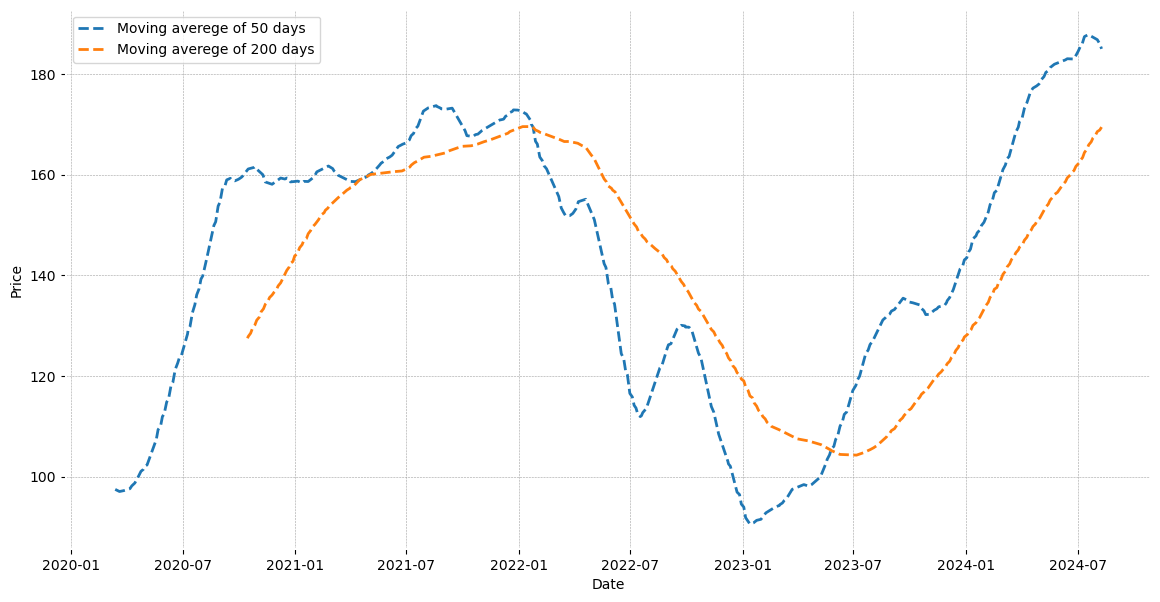

In [42]:
#Now let us visualize moving average for the data
close_mean_50 = df['Close'].rolling(window = 50).mean()
close_mean_200 = df['Close'].rolling(window = 200).mean()

#Plotting the data
plt.figure(figsize = (14,7))
plt.plot(close_mean_50 ,label = "Moving averege of 50 days",linestyle ='--')
plt.plot(close_mean_200 ,label = "Moving averege of 200 days",linestyle ='--')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()
plt.plot()

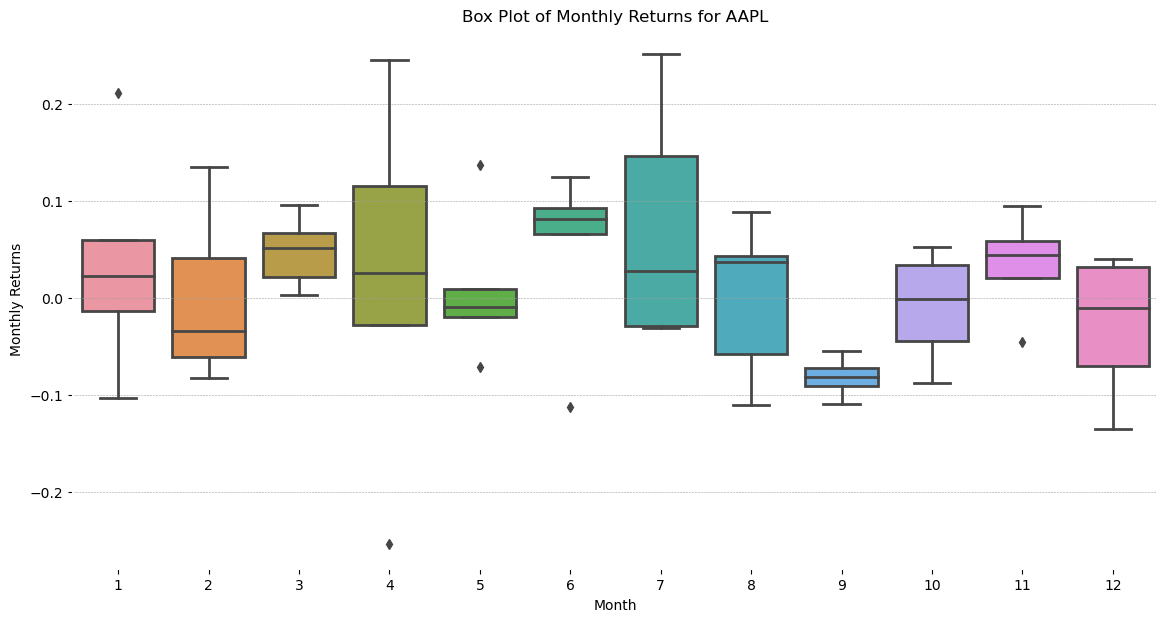

In [43]:
#  Box Plot of Monthly Returns
returns = df['Close'].pct_change().dropna()
returns_df = returns.to_frame()
returns_df['YearMonth'] = returns_df.index.to_period('M')
monthly_returns = returns_df.groupby('YearMonth')['Close'].sum()

plt.figure(figsize=(14, 7))
sns.boxplot(x=monthly_returns.index.month, y=monthly_returns)
plt.title('Box Plot of Monthly Returns for AAPL')
plt.xlabel('Month')
plt.ylabel('Monthly Returns')
plt.show()

# Starting fourier transformation



C:\Users\dixit\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


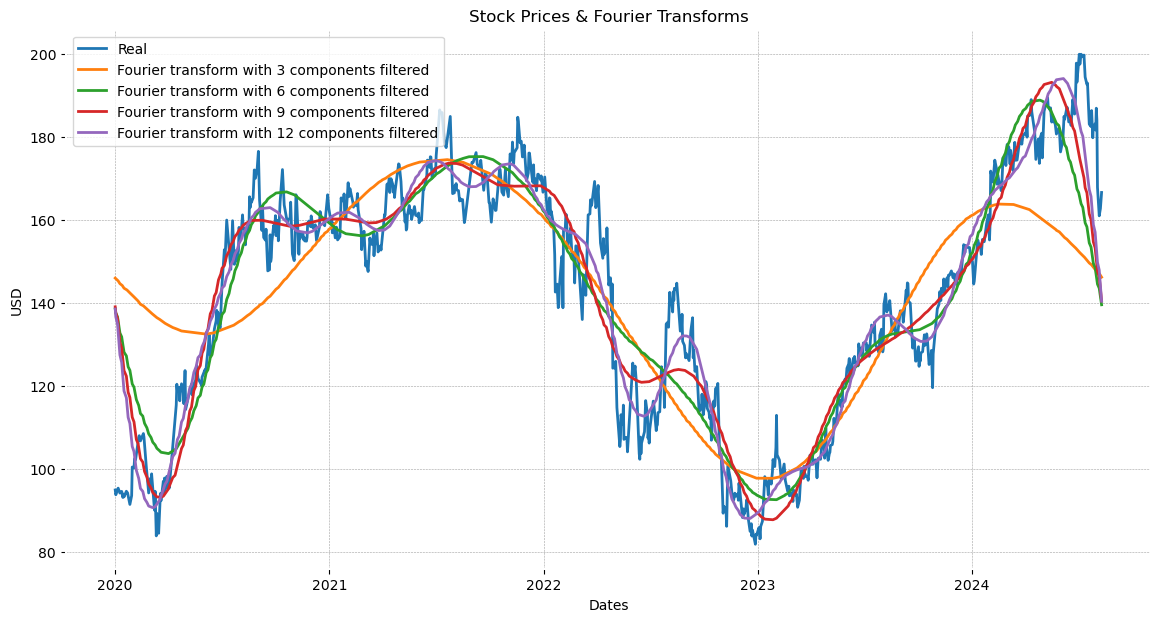

In [44]:
dataset_ex_df = df[['Close']]
# Fourier Transform
data_FT = dataset_ex_df[['Close']]
close_fft = np.fft.fft(data_FT['Close'].values)
fft_df = pd.DataFrame({
    'fft': close_fft,
    'absolute': np.abs(close_fft),
    'angle': np.angle(close_fft)
})

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(data_FT.index, data_FT['Close'], label='Real')

# Plot reconstructions with filtered frequencies
for num in [3, 6, 9,12]:
    fft_list_filtered = np.copy(close_fft)
    fft_list_filtered[num:-num] = 0  # Zero out some frequencies
    filtered_data = np.fft.ifft(fft_list_filtered)
    plt.plot(data_FT.index, filtered_data, label=f'Fourier transform with {num} components filtered')

plt.xlabel('Dates')
plt.ylabel('USD')
plt.title('Stock Prices & Fourier Transforms')
plt.legend()
plt.show()

# Feature enginering

In [45]:
# Calculate EMA(Exponential moving average)
def ema(close, period):
    return close.ewm(span = period, adjust = False).mean()

In [46]:
# Calculate RSI (Relative Strength Index)
def rsi(close, period):
    delta = close.diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(period).mean()
    avg_loss = abs(loss.rolling(period).mean())
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

In [47]:
# Calculate MACD(Moving Average Convergence Divergence)
def macd(close, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = close.ewm(span=fast_period, adjust=False).mean()
    slow_ema = close.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    return macd_line

In [48]:
# Calculate OBV(On-Balance Volume)
def obv(close, volume):
    obv = np.where(close > close.shift(),volume,
                   np.where(close < close.shift(), -volume, 0)).cumsum()
    return obv


#Note 
orignal period for rsi is 14 but here is 10 so change it if something burts

In [49]:
#Adding technichal indicaters to our original dataset

#Copying the origional dataset to add extra features
tech_df = df.copy()

#Adding volumne and close of one day before to make all the features
tech_df['y_Volume']= df['Volume'].shift(1)
tech_df['y_Close']= df['Close'].shift(1)

#Calculating features for exponential moving average with period 10,20 and 50
tech_df['ema10'] = ema(tech_df['y_Close'],10)
tech_df['ema20'] = ema(tech_df['y_Close'],20)
tech_df['ema50'] = ema(tech_df['y_Close'],50)

#Calculating feature for RSI for 10 days
tech_df['rsi'] = rsi(tech_df['y_Close'],10)

#Calculating feature for MACD
tech_df['macd'] = macd(tech_df['y_Close'])

#Calculating feature for OBV
tech_df['obv'] = obv(tech_df['y_Close'], tech_df['y_Volume'])

#Calculating features for fourier teansform
# Reset index of fft_df and add the original index as a new column
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(tech_df.index)

# Set the new datetime index
fft_df.set_index('index', inplace=True)

# Create DataFrames for the real and imaginary parts of the FFT
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

# Adding fourier transform features in technichal indicater dataframe by concatination
tech_df = pd.concat([tech_df,fft_df_real,fft_df_imag ],axis = 1)
#extracting important fearures and removing some initial values because of 'NaN'
tech_df = tech_df[['Close','Open','y_Close','y_Volume','ema10','ema20','ema50','rsi','macd','obv','Fourier_real','Fourier_imag']][20:]
#Dictionary to maintain all the results records
results ={}


#NOTE use this code to inverse transform
#Inverse transform 
scaled_tech_data_inverse = scaler.inverse_transform(scaled_tech_data)
#Inverse transform 
scaled_tech_data_inverse = scaler.inverse_transform(scaled_tech_data)
scaled_tech_data_inverse_test_df = pd.DataFrame(scaled_tech_data_inverse, columns = scaled_tech_df.columns)



#Note tech_df is orignal and final dataframe on which all the models will apply

#Note Do Timeseriescrossvalidatn at tje end with all the models

In [50]:
#Splitting the data feature and target
y =tech_df[['Close']]
x =tech_df.drop(columns ='Close')
trainlen = int(len(x)*0.8)
xtrain,ytrain = x[:trainlen],y[:trainlen]
xtest,ytest = x[trainlen:],y[trainlen:]

In [51]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

xtrain_scaled = scaler_x.fit_transform(xtrain)
xtest_scaled = scaler_x.transform(xtest)

ytrain_scaled = scaler_y.fit_transform(ytrain.values.reshape(-1, 1)).flatten()
#ytest = scaler_y.transform(ytest.values.reshape(-1, 1)).flatten()

#Copying some values for future use
xtrain_scaled_copy,ytrain_scaled_copy,xtest_scaled_copy,ytest_copy = xtrain_scaled,ytrain_scaled,xtest_scaled,ytest.copy()


In [52]:
#A function to predict how man
def rightWrongCheck(ytest,ypred,xtest):
    ytest = ytest.copy()
    ytest['pd'] = ypred['Close'] - xtest['Open'] 
    ytest['od'] = ytest['Close'] - xtest['Open']  

    right = 0
    profit = 0
    wrong = 0
    for i in range(0,len(ytest)):
        if((ytest['pd'][i] * ytest['od'][i]) > 0):
            right = right +1
            profit = profit + abs(ytest['od'][i])
            continue
        wrong = wrong +1
        profit = profit - abs(ytest['od'][i])
    return right,wrong,profit

In [53]:
#Fucntion for evaluating for all models
def modelEvaluater(name,ytest,ypred):
    
    # Evaluate the model
    mse = mean_squared_error(ytest, ypred)
    r2 = r2_score(ytest, ypred)
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    
    right,wrong,profit = rightWrongCheck(ytest,ypred,xtest)
    print(f'right : {right} \nwrong : {wrong} \nprofit : {profit}')
    
    results[name] = {'mse':mse,'r2':r2,'right':right,'wrong': wrong,'profit' :profit}
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(ytest, label='True Values')
    plt.plot(ypred, label='Predictions', color='red')
    plt.legend()
    plt.title(f'Stock Market Predictions using {name}')
    plt.xlabel('Date')
    plt.ylabel('Target Value')
    plt.show()


# Linear Regression

Mean Squared Error: 8.559286496642478
R-squared: 0.9811748733948934
right : 118 
wrong : 110 
profit : 20.970130920410156


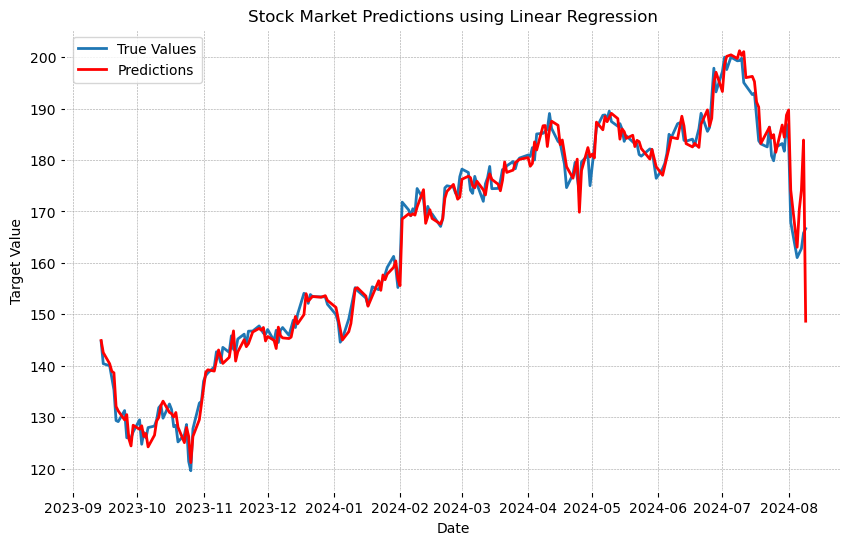

In [54]:
#Create liner regression model object
model = LinearRegression()

#Fitting data to model
model.fit(xtrain_scaled,ytrain_scaled)

#Making predictions
ypred_scaled = model.predict(xtest_scaled)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater("Linear Regression",ytest,ypred)




# Polynomeal regressor

Mean Squared Error: 5.024790798041849
R-squared: 0.988948573812266
right : 123 
wrong : 105 
profit : 56.32988739013672


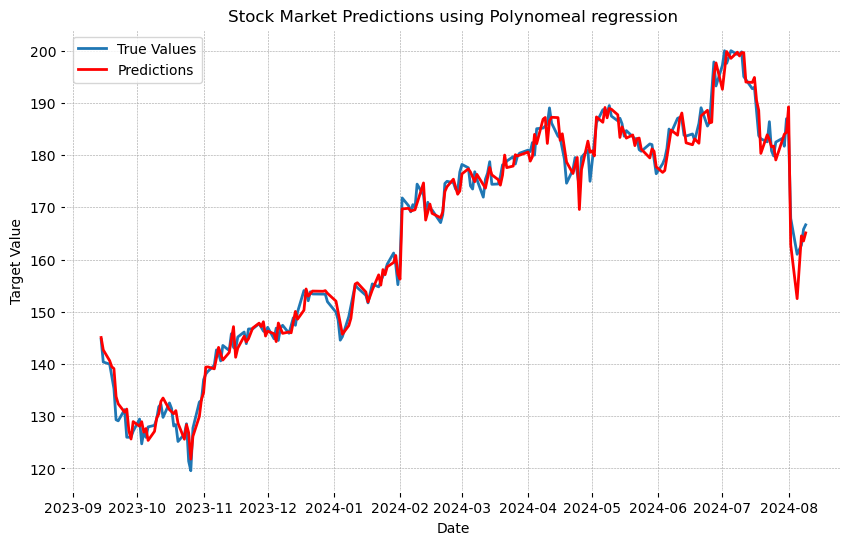

In [55]:
# Degree of the polynomial
degree = 2

# Polynomial modeling of data
poly_features = PolynomialFeatures(degree=degree)
xtrain_poly = poly_features.fit_transform(xtrain[['y_Close','y_Volume','Open','ema10','ema20','ema50']])
xtest_poly = poly_features.transform(xtest[['y_Close','y_Volume','Open','ema10','ema20','ema50']])

#Creating polynomial Regression object
polynomial_regression_model = LinearRegression()

#Fitting data to model
polynomial_regression_model.fit(xtrain_poly,ytrain)

#Making predictions
ypred = polynomial_regression_model.predict(xtest_poly)

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater('Polynomeal regression',ytest,ypred)

# Decesion Tree Regressor

Mean Squared Error: 33.17438283277042
R-squared: 0.9270369139859784
right : 107 
wrong : 121 
profit : -15.489997863769531


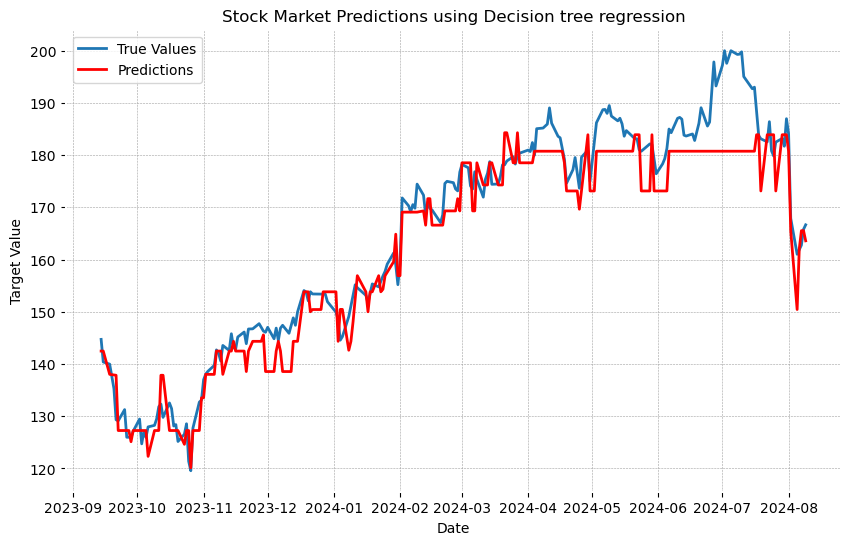

In [56]:
#Creating decision tree object with limiting max depth 7
tree = DecisionTreeRegressor(max_depth=7)

#Fitting data to model
tree.fit(xtrain_scaled,ytrain_scaled)

#Making predictions
ypred_scaled = tree.predict(xtest_scaled)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater('Decision tree regression',ytest,ypred)

# Random Forest Regressor

Mean Squared Error: 21.114197562599514
R-squared: 0.9535618485913415
right : 122 
wrong : 106 
profit : 18.130027770996094


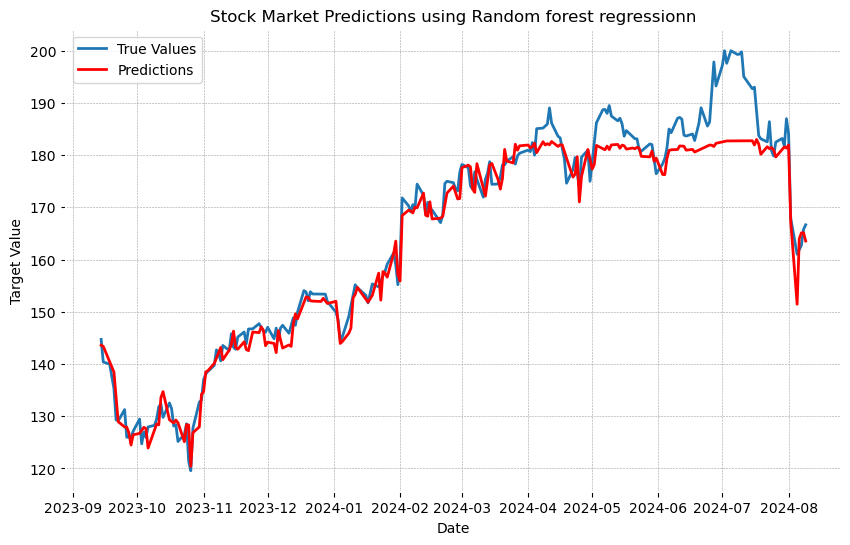

In [57]:
#Creating random forest object
rfr = RandomForestRegressor(random_state=42)

#Fitting data to model
rfr.fit(xtrain_scaled,ytrain_scaled)

#Making predictions
ypred_scaled = rfr.predict(xtest_scaled)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater('Random forest regressionn',ytest,ypred)

# Gradient boost regressor

Mean Squared Error: 18.4094218276796
R-squared: 0.9595106792173826
right : 114 
wrong : 114 
profit : -8.390052795410156


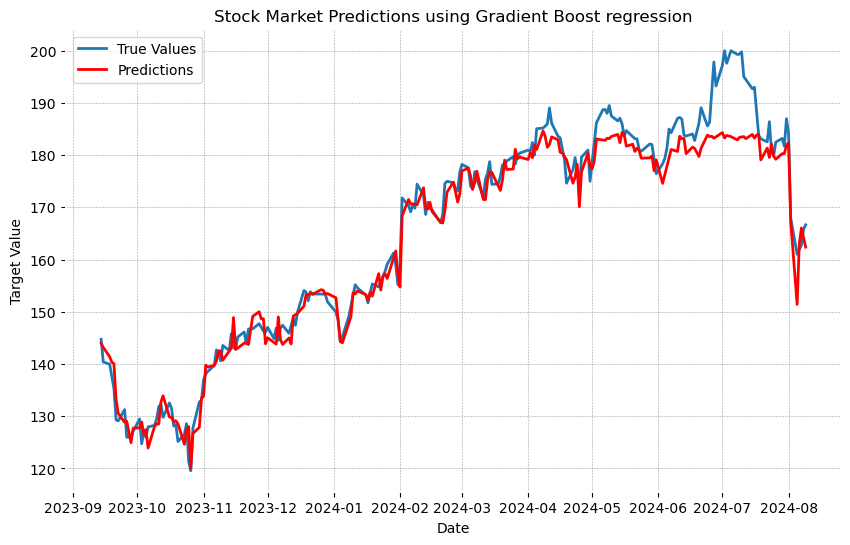

In [58]:
#Creating gradient boost object
gradient_boost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

#Fitting data to model
gradient_boost.fit(xtrain_scaled,ytrain_scaled)

#Making predictions
ypred_scaled =gradient_boost.predict(xtest_scaled)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater('Gradient Boost regression',ytest,ypred)



# Support Vector Regressor(SVR)

Mean Squared Error: 855.6424725325182
R-squared: -0.8818832481480305
right : 102 
wrong : 126 
profit : -27.36998748779297


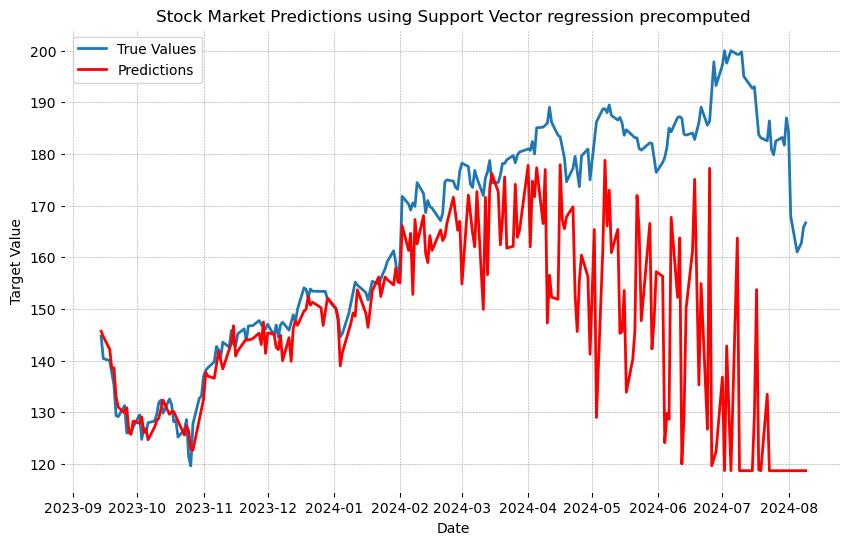

In [62]:
#Setting up kernet value
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
k = kernel[4]
#Creating svr object
svr = SVR(kernel= k)
svr = SVR()

#Fitting data to model
svr.fit(xtrain_scaled,ytrain_scaled)

#Making predictions
ypred_scaled =svr.predict(xtest_scaled)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater(f'Support Vector regression {k}',ytest,ypred)

# ARIMA Model

Mean Squared Error: 8.510928108534733
R-squared: 0.9812812997787758
right : 117 
wrong : 111 
profit : 20.439231872558594


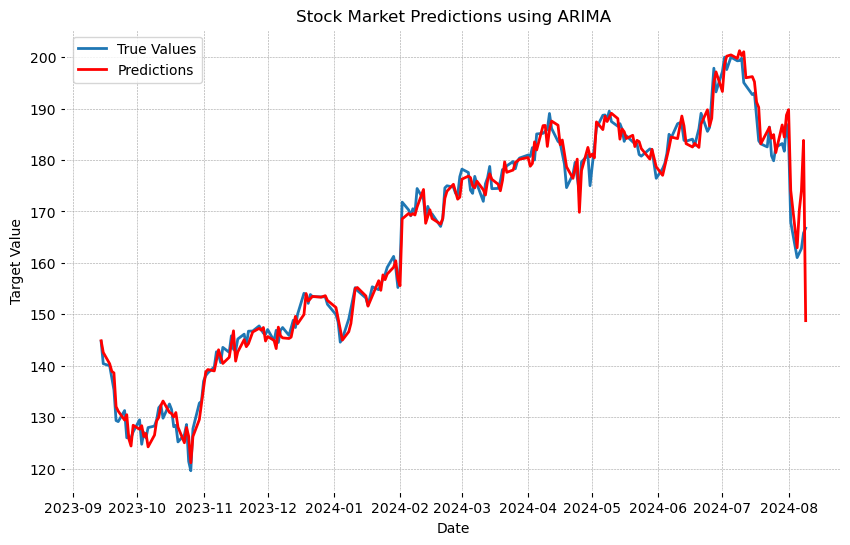

In [26]:
#Making model object
arima = ARIMA(endog = ytrain_scaled_copy , exog = xtrain_scaled_copy , order = (1,0,0)).fit()

#Predincting data
ypred_scaled = arima.forecast(steps = len(xtest_scaled_copy) ,exog = xtest_scaled_copy)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

#evaluate model
modelEvaluater('ARIMA',ytest,ypred)


# LSTM Model

In [27]:
x_scaler_lstm = StandardScaler()
y_scaler_lstm = StandardScaler()
x_lstm= x_scaler_lstm.fit_transform(tech_df.drop(columns ='Close'))
y_lstm = y_scaler_lstm.fit_transform(tech_df[['Close']])

In [28]:
# Create sequences of data for the LSTM model
def create_sequences(xtrain_scaled,ytrain_scaled,seq_length):
    xs, ys = [], []
    for i in range(len(xtrain_scaled) - seq_length):
        x = xtrain_scaled[i:i+seq_length]
        y = ytrain_scaled[i+seq_length]  
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [29]:
SEQ_LENGTH = 10  # Sequence length can be adjusted
X,y = create_sequences(x_lstm,y_lstm , SEQ_LENGTH)

In [30]:
# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [31]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10)

# Make predictions
predictions = model.predict(X_test)


Epoch 1/10

903/903 [==============================] - 14s 9ms/step - loss: 0.0904
Epoch 2/10
903/903 [==============================] - 8s 9ms/step - loss: 0.0635
Epoch 3/10
903/903 [==============================] - 9s 10ms/step - loss: 0.0536
Epoch 4/10
903/903 [==============================] - 9s 10ms/step - loss: 0.0533
Epoch 5/10
903/903 [==============================] - 9s 10ms/step - loss: 0.0520
Epoch 6/10
903/903 [==============================] - 9s 9ms/step - loss: 0.0419
Epoch 7/10
903/903 [==============================] - 8s 9ms/step - loss: 0.0469
Epoch 8/10
903/903 [==============================] - 8s 9ms/step - loss: 0.0418
Epoch 9/10
903/903 [==============================] - 8s 9ms/step - loss: 0.0410
Epoch 10/10
8/8 [==============================] - 1s 8ms/step


In [33]:
#Inverse transform predicted and scaled values
y_pred_unscaled = y_scaler_lstm.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_unscaled = y_scaler_lstm.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [34]:
# making predicted values and orignal values compatible for modelEvaluater() function by converting that to a dataframe  
len_lstm_test = len(y_pred_unscaled) 
total_len = len(tech_df)
xtest =tech_df[['Open','Close']].iloc[(total_len-len_lstm_test):]

xtest['Close_ytest'] = y_test_unscaled
ytest = xtest[['Close']]
ypred = pd.DataFrame(y_pred_unscaled , index=  ytest.index ,columns = ['Close']) 

Mean Squared Error: 26.364662194510704
R-squared: 0.9419668990837077
right : 112 
wrong : 114 
profit : 21.75904083251953


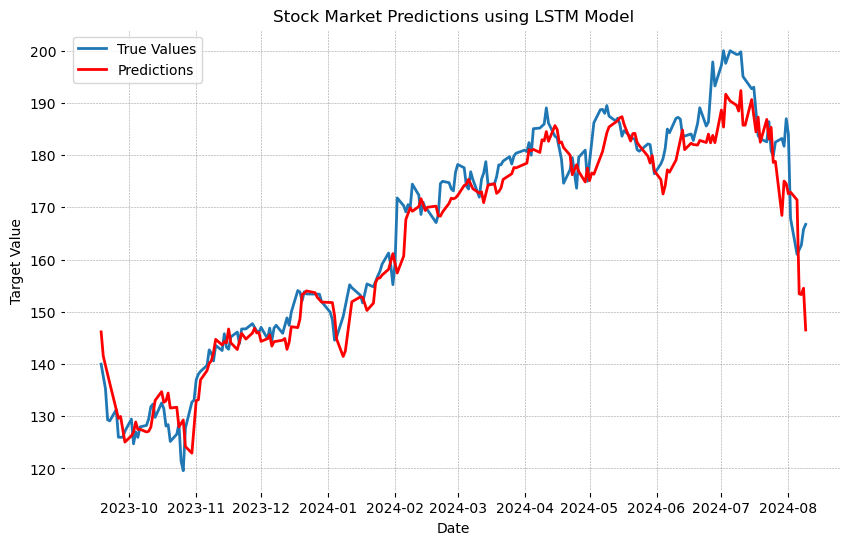

In [35]:
#Nodel evaluation
modelEvaluater("LSTM Model",ytest,ypred)

In [36]:
results

{'Linear Regression': {'mse': 8.57144318160269,
  'r2': 0.9811482045984171,
  'right': 118,
  'wrong': 110,
  'profit': 20.879234313964844},
 'Polynomeal regression': {'mse': 5.026059607624841,
  'r2': 0.9889458233121733,
  'right': 123,
  'wrong': 105,
  'profit': 56.238990783691406},
 'Decision tree regression': {'mse': 32.704338369454284,
  'r2': 0.9280709814412129,
  'right': 107,
  'wrong': 121,
  'profit': -15.580894470214844},
 'Random forest regressionn': {'mse': 21.114624864854076,
  'r2': 0.9535610772305235,
  'right': 122,
  'wrong': 106,
  'profit': 18.03913116455078},
 'Gradient Boost regression': {'mse': 19.606688811546576,
  'r2': 0.9568775901389492,
  'right': 117,
  'wrong': 111,
  'profit': 3.0390853881835938},
 'Support Vector regression': {'mse': 855.6776067132263,
  'r2': -0.8819536955103107,
  'right': 102,
  'wrong': 126,
  'profit': -27.46088409423828},
 'ARIMA': {'mse': 8.510928108534733,
  'r2': 0.9812812997787758,
  'right': 117,
  'wrong': 111,
  'profit': 2